In [2]:
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import numpy as np

from sklearn.cluster import KMeans

In [3]:
data=pd.read_csv("result_interaction_atf.csv")
interaction_array=np.array(data['Interaction'])
interaction_with_array=np.array(data['Interact_with'])

In [4]:
data

,Id,x,y,Expression,Action,Gesture,Interaction,Interact_with
0,person1,182,80,Neutral,Sitting,Down,reading,book
1,person1,176,81,Neutral,Sitting,Down,reading,book
2,person1,174,82,Neutral,Sitting,Down,reading,book
3,person1,174,83,Neutral,Sitting,Down,reading,book
4,person1,173,84,Neutral,Sitting,Down,reading,book
...,...,...,...,...,...,...,...,...
151,person1,548,547,None,Sitting,Down,drinking,bottle
152,person1,558,543,None,Walking,Down,drinking,bottle
153,person1,556,555,None,Walking,Down,drinking,bottle
154,person1,549,548,None,Walking,Down,drinking,bottle


In [5]:
data2=data.loc[:,['x','y']]

In [6]:
data2

,x,y
0,182,80
1,176,81
2,174,82
3,174,83
4,173,84
...,...,...
151,548,547
152,558,543
153,556,555
154,549,548


In [7]:
data3 = [list(e) for e in zip(data['x'],data['y'])]

In [9]:
data3

[[182, 80],
 [176, 81],
 [174, 82],
 [174, 83],
 [173, 84],
 [173, 85],
 [166, 86],
 [158, 87],
 [159, 88],
 [169, 89],
 [187, 88],
 [195, 91],
 [205, 92],
 [217, 93],
 [235, 94],
 [248, 95],
 [258, 96],
 [265, 97],
 [274, 98],
 [278, 99],
 [278, 88],
 [279, 85],
 [280, 81],
 [275, 93],
 [271, 92],
 [261, 100],
 [247, 89],
 [233, 86],
 [219, 82],
 [206, 94],
 [196, 93],
 [186, 101],
 [184, 90],
 [186, 87],
 [193, 83],
 [199, 95],
 [206, 94],
 [215, 102],
 [224, 91],
 [230, 88],
 [228, 84],
 [218, 96],
 [203, 95],
 [190, 103],
 [177, 92],
 [162, 89],
 [150, 85],
 [66, 97],
 [66, 96],
 [66, 97],
 [66, 98],
 [133, 99],
 [136, 88],
 [146, 85],
 [161, 81],
 [175, 93],
 [185, 92],
 [191, 100],
 [191, 89],
 [184, 86],
 [177, 82],
 [167, 97],
 [163, 98],
 [166, 99],
 [169, 100],
 [173, 89],
 [175, 86],
 [174, 82],
 [172, 94],
 [163, 93],
 [156, 101],
 [156, 90],
 [155, 87],
 [153, 83],
 [148, 98],
 [146, 99],
 [145, 100],
 [151, 101],
 [162, 90],
 [171, 87],
 [175, 83],
 [180, 95],
 [187, 94],

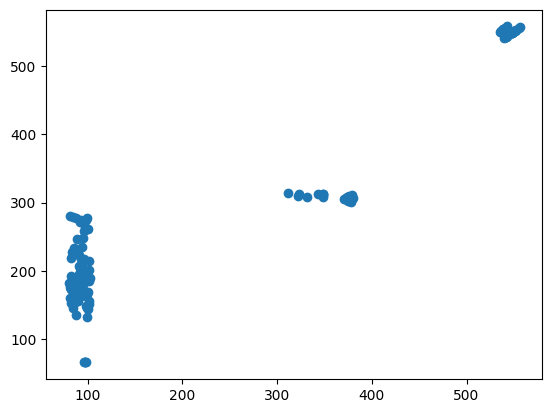

In [10]:
data=pd.read_csv("result_interaction_atf.csv")
plt.scatter(data.loc[:, ['y']], data.loc[:, ['x']])

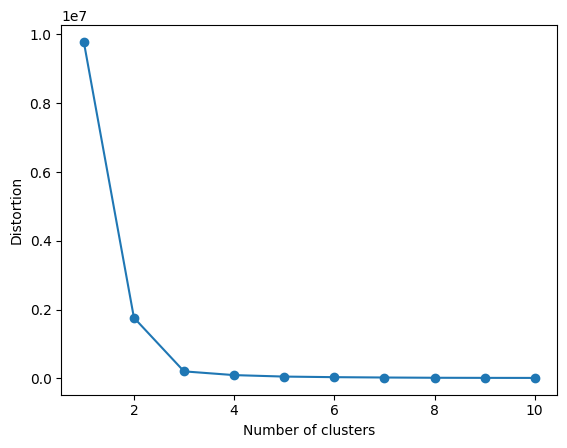

In [11]:
#elbow
distortions = []

for i in range(1,11):                 
    km = KMeans(n_clusters=i,
                init='k-means++',     
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(data3)                        
    distortions.append(km.inertia_)   

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [12]:
km = KMeans(n_clusters=3, random_state=42)
label = km.fit_predict(data2[:])

In [13]:
label

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2], dtype=int32)

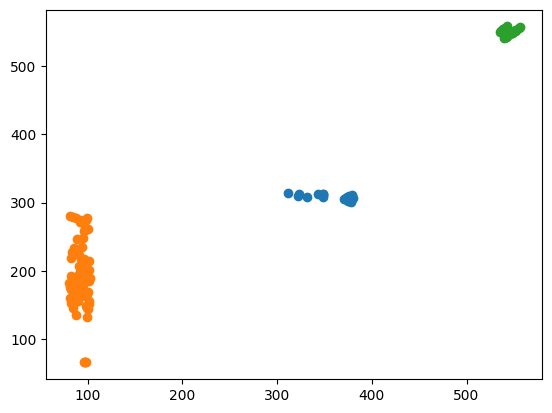

In [14]:
plt.scatter(data.loc[:, ['y']][label==0], data.loc[:, ['x']][label==0])
plt.scatter(data.loc[:, ['y']][label==1], data.loc[:, ['x']][label==1])
plt.scatter(data.loc[:, ['y']][label==2], data.loc[:, ['x']][label==2])
plt.show()

In [15]:
from gensim.models import KeyedVectors
model_dir = 'wiki-news-300d-1M.vec'
model = KeyedVectors.load_word2vec_format(model_dir, binary=False)

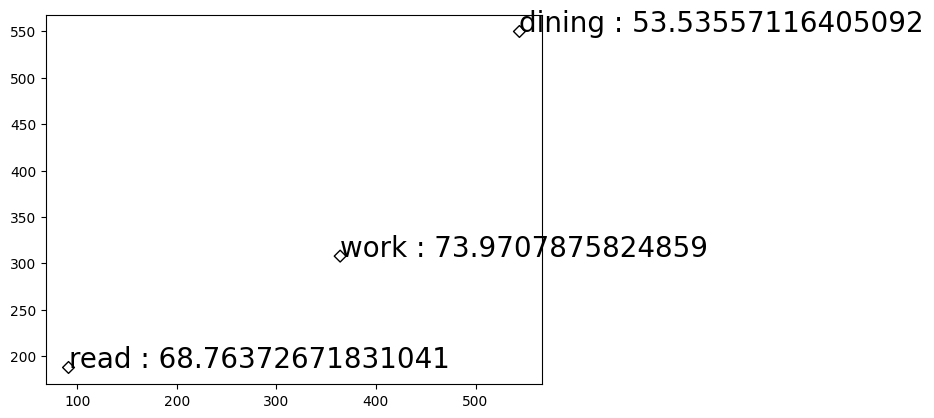

In [241]:
dd1=data.loc[:, ['y']][label==0]
ddList1 = dd1["y"].index.to_list()
dd2=data.loc[:, ['y']][label==1]
ddList2 = dd2["y"].index.to_list()
dd3=data.loc[:, ['y']][label==2]
ddList3 = dd3["y"].index.to_list()

observedList1 =[]
for i in ddList1:
    observedList1.append(interaction_array[i])
    observedList1.append(interaction_with_array[i])

observedList2 =[]
for i in ddList2:
    observedList2.append(interaction_array[i])
    observedList2.append(interaction_with_array[i]) 

observedList3 =[]
for i in ddList3:
    observedList3.append(interaction_array[i])
    observedList3.append(interaction_with_array[i])

centers = km.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], marker="D", facecolors='none', edgecolors='black')
observed_lists = [observedList1, observedList2, observedList3]
utilization_class_list = ['work','relax','dining','read','aisle']

for i, observed_list in enumerate(observed_lists):
    score = [np.mean([model.similarity(utilization, observe) for observe in observed_list]) 
             for utilization in utilization_class_list]
    max_socre = np.max(score)

    similar_list = model.most_similar(f"{utilization}")
    most_similar_score =similar_list[0][1]
    prob = max_socre / most_similar_score *100

    max_index = np.argmax(score)
    utilization = utilization_class_list[max_index]
    if prob>50:
        plt.text(centers[i][1], centers[i][0], f"{utilization} : {prob}", fontsize=20)


In [146]:
similar_list = model.most_similar('work')
for similar_set in similar_list:
    print(str(similar_set[0])+ " : " + str(similar_set[1]))

works : 0.717581570148468
working : 0.6682043671607971
job : 0.6681519746780396
Work : 0.642331063747406
work. : 0.6332440972328186
research : 0.6295222640037537
work- : 0.6242907047271729
doing : 0.6225779056549072
effort : 0.6146255731582642
work-- : 0.6137425303459167
